In [1]:
import huracanpy
# setup
import xarray as xr
import uxarray as ux
import numpy as np
from tqdm import tqdm
from dask.distributed import Client, LocalCluster, progress, as_completed
import glob
import re

# load in pyPI modules
from tcpyPI import pi
#from tcpyPI.utilities import *

import intake
from easygems import healpix as egh

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)# don't warn us about future package conflicts
warnings.filterwarnings("ignore", category=UserWarning)

import healpy as hp

#my packages
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.colors as mcolors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
n_workers=16
n_cpu=16
memory_limit="50GB"
processes=True

cluster = LocalCluster(n_workers=n_workers, 
                       threads_per_worker=n_cpu // n_workers,
                       memory_limit=memory_limit,
                       processes=processes,
                       dashboard_address=46861)
client = Client(cluster)

# Load PI data

In [3]:
complete_fields=False
#sim_name = "icon_d3hp003"
#sim_name = "ifs_tco3999-ng5_deepoff"
sim_name = "um_glm_n2560_RAL3p3"
out_dir = "/work/bb1153/b383007/hk25-hamburg/out_data/"
plot_dir = "/work/bb1153/b383007/hk25-hamburg/out_plots/"
if complete_fields:
    out_dir = out_dir + "complete_fields/"
    files = sorted(glob.glob(out_dir+f"{sim_name}*"))
    files_grid = files[0]
    files = files[1:]
    dspi = ux.open_mfdataset(files_grid, files, 
                             combine='nested', concat_dim='time', parallel=True)
    dspi = dspi.chunk(chunks={"time":100, "n_face":2048})
    #dspi = xr.open_mfdataset(files, concat_dim="time", combine='nested')
    #dspi = ux.UxDataset.from_healpix(dspi)
else:
    out_dir = out_dir + "only_tracks/"
    files = sorted(glob.glob(out_dir+f"{sim_name}*"))
    files_grid = [f for f in files if any(kw in f for kw in ['grid'])]
    files = [f for f in files if not any(kw in f for kw in ['grid'])]
    #dspi = [ux.open_dataset(file) for file_grid, file in zip(files_grid, files)]

In [4]:
if complete_fields:
    zoom_level = dspi.uxgrid.attrs["zoom"]
    time_res = np.diff(dspi.time)[0] // np.timedelta64(1, 'h')
else:
    zoom_level = int(re.search(r'zoom_(\d+)', files[0]).group(1))
    time_res =  np.diff(xr.open_dataset(files[0]).time)[-1]// np.timedelta64(1, 'h')

print(f"Zoom level: {zoom_level}")
print(f"Time resolution: {time_res}")

current_location = "EU"
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")[current_location]

if "um_" in sim_name:
    ds2d = cat[sim_name](zoom=zoom_level).to_dask()

    vnames = {"sst":"ts", "psl":"psl", "t":"ta", "q":"hus", "cell":"cell"}

    ds3d = cat[sim_name](zoom=zoom_level, time="PT3H").to_dask()
    
    dim="pressure"
    
if "icon_" in sim_name:
    ds2d = cat[sim_name](zoom=zoom_level, time='PT6H', time_method='inst').to_dask()
    
    vnames = {"sst":"ts", "psl":"psl", "t":"ta", "q":"hus", "cell":"cell", "land_mask":"sftlf"}

    ds3d = ds2d.copy()

    dim="pressure"
    ds3d = ds3d.assign_coords(pressure=ds3d[dim]/100)
if "ifs_" in sim_name:
    ds2d = cat[sim_name](zoom=zoom_level, dim="2D").to_dask()
    
    vnames = {"sst":"sst", "psl":"msl", "t":"t", "q":"q", "cell":"value", "land_mask":"sftlf"}

    ds3d = cat[sim_name](zoom=zoom_level, dim="3D").to_dask()

    dim="level"

ds3d = ds3d.sortby(dim, ascending=False)
time= ds2d.time.where(ds2d.time.dt.hour % time_res == 0, drop=True)

ds2d = ds2d.rename({vnames["cell"]: "cell"})
ds3d = ds3d.rename({vnames["cell"]: "cell"})

#ds2d = ds2d.chunk(chunks={'time':len(time), 'cell':2048})
#ds3d = ds3d.chunk(chunks={'time':len(time), 'cell':2048})

ds2d = ux.UxDataset.from_healpix(ds2d, pixels_only=False)
ds3d = ux.UxDataset.from_healpix(ds3d, pixels_only=False)

#land mask
if "icon_" in sim_name:
   mask = ds3d[vnames["land_mask"]].isnull()
   #ds3d = ds3d.where(mask)
   # dspi = dspi.where(mask)

Zoom level: 7
Time resolution: 6


# Plot all tracks

(<Figure size 1000x1000 with 1 Axes>, <GeoAxes: xlabel='lon', ylabel='lat'>)

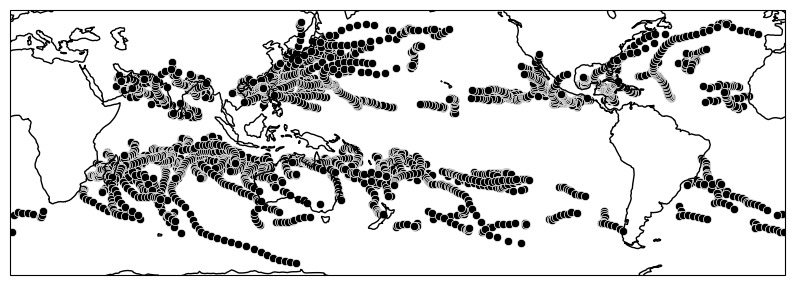

In [5]:
if not "icon_" in sim_name:
    ftrack = f"../TC_tracks/{sim_name}.csv"
else:
    ftrack = f"../TC_tracks/2D/{sim_name}.csv"
tracks = huracanpy.load(ftrack)
tracks.hrcn.plot_tracks()

# Plot PI fields for single timesteps

In [6]:
tid = 0
ti = 0
vname="vmax"
margin_deg = 10
dt = np.timedelta64(0, "D")

tsel = tracks.where(tracks.track_id==tid, drop=True)
if complete_fields:
    out_ds = ux.open_dataset(files_grid, files[ti])
    var = out_ds[vname]#.where(mask)
else:
    def get_snapshot(files_grid, files, tid):
        mask = [f"track_{tid:04d}" in s for s in files_grid]
        return [s for s, m in zip(files_grid, mask) if m], \
               [s for s, m in zip(files, mask) if m]

    files_grid_track, files_track = get_snapshot(files_grid, files, tid)
    out_ds = ux.open_dataset(files_grid_track[ti], files_track[ti])
    t_shifted = np.clip(tsel.time[ti]-dt, ds2d.time[0], ds2d.time[-1]).values
    var = out_ds[vname].sel(time=t_shifted-dt)
    if var.time.shape!=():
        var=var.drop_duplicates("time")[0]

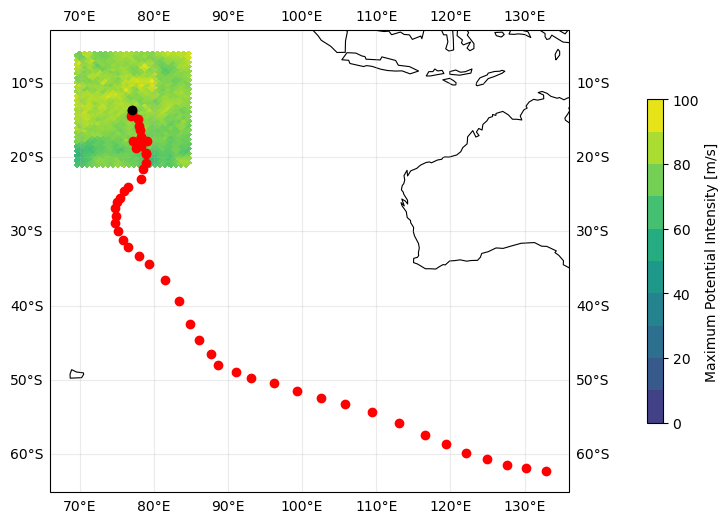

In [7]:
'''new plotting with uxarray'''
def restrict_colormap(cmap, interval, levels):
    cmap_ = plt.get_cmap(cmap)
    colors = cmap_(interval, levels)
    return mcolors.LinearSegmentedColormap.from_list(cmap, colors)

def plot_pi(vname, ncolors = 11):
    if vname=="vmax":
        vmin, vmax = 0, 100
    elif vname=="pmin":
        vmin, vmax = 800, 1000
    elif vname=="t0":
        vmin, vmax = 200, 300
    cmap = restrict_colormap('viridis', np.linspace(0.15, 1), ncolors)
    levels = np.linspace(vmin, vmax, ncolors)
    norm=mcolors.Normalize(levels[0], levels[-1])
    
    return vmin, vmax, norm, cmap, levels

if complete_fields:
    lon_bounds = [out_ds.uxgrid.node_lon.min(), out_ds.uxgrid.node_lon.max()]
    lat_bounds = [out_ds.uxgrid.node_lat.min(), out_ds.uxgrid.node_lat.max()]
else:
    max_lon = out_ds.uxgrid.node_lon.max()+margin_deg
    min_lon = out_ds.uxgrid.node_lon.min()-margin_deg
    if max_lon>180:
        max_lon = max_lon -360
        central_lon = 180
    elif min_lon<-180:
        min_lon = 360 - abs(min_lon)
        central_lon = 180
    else:
        central_lon=0
    lon_bounds = [min_lon, max_lon]
    lat_bounds = [out_ds.uxgrid.node_lat.min()-margin_deg, 
                  out_ds.uxgrid.node_lat.max()+margin_deg]

vmin, vmax, norm, cmap, levels = plot_pi(vname)

pc = var.to_polycollection(projection=ccrs.PlateCarree(central_longitude=central_lon))
pc.set_antialiased(False)
pc.set_cmap(cmap)
pc.set_clim(vmin, vmax)

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree(central_longitude=central_lon)})
ax.add_collection(pc)

ax.scatter(tsel.lon+central_lon, tsel.lat, color='r', marker='o', zorder=3)
ax.scatter(tsel.lon[ti]+central_lon, tsel.lat[ti], color='k', marker='o', zorder=3)

#ax.set_extent([np.min(lon_bounds), np.max(lon_bounds), lat_bounds[0], lat_bounds[-1]])
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.25)

#ax.set_extent([-85, -65, 20, 35])
ax.coastlines(lw=0.8)
fig.colorbar(pc, boundaries=levels, label=f"{var.standard_name} [{var.units}]",
             shrink=0.7, pad=0.1)

In [ ]:
vname="vmax"
ti = 0

def restrict_colormap(cmap, interval, levels):
    cmap_ = plt.get_cmap(cmap)
    colors = cmap_(interval, levels)
    return mcolors.LinearSegmentedColormap.from_list(cmap, colors)

def plot_pi(vname, ncolors = 11):
    if vname=="vmax":
        vmin, vmax = 0, 150
    elif vname=="pmin":
        vmin, vmax = 800, 1000
    elif vname=="t0":
        vmin, vmax = 200, 300
    cmap = restrict_colormap('viridis', np.linspace(0.15, 1), ncolors)
    levels = np.linspace(vmin, vmax, ncolors)
    norm=mcolors.Normalize(levels[0], levels[-1])
    
    return vmin, vmax, norm, cmap, levels

vmin, vmax, norm, cmap, levels, var = plot_pi(vname, out_ds.time[ti])

#cmap=plt.get_cmap('viridis', ncolors)

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.25)
#ax.set_extent([-180, 180, -90, 90])
#ax.set_extent([-85, -65, 20, 35])
ax.coastlines(lw=0.8)
ax.set_title(out_ds.time.values[0])

llat, llon = np.meshgrid(lat, lon)
pc = ax.pcolormesh(llon, llat, var.transpose(), 
                 cmap=cmap, norm=norm)

track = tracks.where(tracks.track_id==tid, drop=True)
ax.plot(track.lon, track.lat, color='r', lw=0.5, ms=5, marker='o')
fig.colorbar(pc, boundaries=levels, label=f"{var.standard_name} [{var.units}]",
             shrink=0.7, pad=0.1)

# Compare PI to tracks

In [8]:
dt = np.timedelta64(3, "D") #dt before cyclone passage for PI computation
do_single_face = False
radius = 500 #km

if "um_" in sim_name:
    vname_wind = "wind_max_925"
else:
    vname_wind = "wind"

def haversine(lon1, lat1, lon2, lat2):
    R = 6371.0  # Earth radius in km

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.atan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c

def get_var_track(vname, ds, faces, t_shifted, tsel):
    var_track = []
    for i in range(len(ds)):
        var_track_i = ds[i][vname].sel(n_face=faces[i], time=t_shifted[i])
        if not do_single_face:
            var_track_i = var_track_i.mean("n_face")
        if not var_track_i.shape==(): #drop duplicates in time
            var_track_i = var_track_i.drop_duplicates("time")
        var_track.append(var_track_i)
    return xr.concat(var_track, dim="time").values

def get_distance(uxgrid):
    face_node_connectivity = uxgrid.face_node_connectivity
    node_lon = uxgrid.node_lon.values
    node_lat = uxgrid.node_lat.values
    # Compute face centroids (handling dateline properly)
    face_centroids = []
    for face_nodes in face_node_connectivity:
        valid_nodes = face_nodes[face_nodes != -1]
        lons = node_lon[valid_nodes]
        lats = node_lat[valid_nodes]
    
        # Convert lon to radians, wrap around 0-360
        lons_rad = np.radians((lons + 360) % 360)
        x = np.cos(lons_rad)
        y = np.sin(lons_rad)
        mean_angle = np.atan2(np.sum(y), np.sum(x))
        centroid_lon = np.degrees(mean_angle) % 360
        if centroid_lon > 180:  # Convert back to [-180, 180]
            centroid_lon -= 360
    
        centroid_lat = np.mean(lats)
        face_centroids.append([centroid_lon, centroid_lat])
    
    face_centroids = np.array(face_centroids)

    lons = np.radians((face_centroids[:, 0] + 360) % 360)
    x = np.cos(lons)
    y = np.sin(lons)
    mean_lon_rad = np.atan2(np.sum(y), np.sum(x))
    mean_lon = np.degrees(mean_lon_rad) % 360
    if mean_lon > 180:
        mean_lon -= 360
    mean_lat = np.mean(face_centroids[:, 1])
    grid_center = (mean_lon, mean_lat)
    
    # Set radius (e.g., 500 km)
    radius_km = 500.0
    
    # Compute geodesic distances using haversine
    distances = np.array([
        haversine(lon, lat, grid_center[0], grid_center[1])
        for lon, lat in face_centroids
    ])
    return distances

In [11]:
results = []

unique_tracks = np.unique(tracks["track_id"].values)

for tid in tqdm(unique_tracks, desc="Interpolating tracks"):
    # Select track
    tsel = tracks.where(tracks.track_id == tid, drop=True)

    if complete_fields:
        t_shifted = tsel["time"].values - dt # Shift time
        t_shifted = tsel["time"] - dt
        #t_shifted = np.clip(t_shifted, dspi.time.values[0], dspi.time.values[-1])

        #find all faces which intersect the tracks. add small tolerance to avoid boundary conflichts (e.g. lon=-180)
        faces = [dspi.uxgrid.get_faces_containing_point(
                 point_lonlat=[tsel.lon[i]+1e-6, tsel.lat[i]])[0] for i in range(len(tsel.time))]
    
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', 'Sending large graph of size', UserWarning) 
            vmax = np.diagonal(dspi["vmax"].sel(n_face=faces, time=t_shifted))
            pmin = np.diagonal(dspi["pmin"].sel(n_face=faces, time=t_shifted))
            t0   = np.diagonal(dspi["t0"]  .sel(n_face=faces, time=t_shifted))
            otl  = np.diagonal(dspi["otl"] .sel(n_face=faces, time=t_shifted))

            vmax_fixts = np.diagonal(dspi["vmax_fixts"].sel(n_face=faces, time=t_shifted))
            pmin_fixts = np.diagonal(dspi["pmin_fixts"].sel(n_face=faces, time=t_shifted))
            t0_fixts   = np.diagonal(dspi["t0_fixts"]  .sel(n_face=faces, time=t_shifted))
            otl_fixts  = np.diagonal(dspi["otl_fixts"] .sel(n_face=faces, time=t_shifted))
        
            sst  = np.diagonal(ds2d[vnames["sst"]].sel(n_face=faces, time=t_shifted))
    else:
        if tid>=len(files):
            break
        files_grid_track, files_track = get_snapshot(files_grid, files, tid)
        ds = [ux.open_dataset(file_grid, file) for file_grid, file in zip(files_grid_track, files_track)]

        if do_single_face:
            faces = [ds[i].uxgrid.get_faces_containing_point(
                     point_lonlat=[tsel.lon[i]+1e-6, tsel.lat[i]])[0] for i in range(len(tsel.time))]
        else:
            #faces = [ds[i].uxgrid.n_face for i in range(len(tsel.time))]
            futures = []
            for i in range(len(ds)):
                futures.append(client.submit(get_distance, ds[i].uxgrid))
            distances = client.gather(futures)
            faces = [ds[i].n_face[np.where(distances[i]<=radius)[0]] for i in range(len(ds))]

        if "icon" in sim_name:
            faces = [faces[i][mask.sel(n_face=faces[i])] for i in range(len(ds))]
                
        t_shifted = [np.clip(tsel.time[i]-dt, ds2d.time[0], ds2d.time[-1]).values for i in range(len(tsel.time))]
        
        vmax = get_var_track("vmax", ds, faces, t_shifted, tsel)
        pmin = get_var_track("pmin", ds, faces, t_shifted, tsel)
        t0   = get_var_track("t0", ds, faces, t_shifted, tsel)
        otl  = get_var_track("otl", ds, faces, t_shifted, tsel)
        sst  = get_var_track("sst", ds, faces, t_shifted, tsel)

        vmax_fixts = get_var_track("vmax_fixts", ds, faces, t_shifted, tsel)
        pmin_fixts = get_var_track("pmin_fixts", ds, faces, t_shifted, tsel)
        t0_fixts   = get_var_track("t0_fixts", ds, faces, t_shifted, tsel)
        otl_fixts  = get_var_track("otl_fixts", ds, faces, t_shifted, tsel)
                                            
        #ds = ds.assign_coords(time=dspi[tid].time.values)
        #t_shifted = tsel["time"].values # Do no shift time (already done in PI_compute)   
        

    # Bounds check for lat/lon
    #in_bounds = (
    #    (tsel["lat"].values >= ds.lat.values.min()) & (tsel["lat"].values <= ds.lat.values.max()) &
    #    (tsel["lon"].values >= ds.lon.values.min()) & (tsel["lon"].values <= ds.lon.values.max())
    #)

    #if not np.any(in_bounds):
    #    continue  # skip invalid track

    # Interpolate
    #interp = ds.interp(
    #    time=xr.DataArray(t_shifted[in_bounds], dims="time"),
    #    lat=xr.DataArray(tsel["lat"].values[in_bounds], dims="time"),
    #    lon=xr.DataArray(tsel["lon"].values[in_bounds], dims="time"),
    #    method="nearest"
    #)

    # Package result
    # n = interp.sizes["time"]
    # results.append(xr.Dataset({
    #     vname: (["point"], interp.data),
    #     "track_id": (["point"], [tid] * n),
    #     "wind_max_925": (["point"], tsel["wind_max_925"].values[in_bounds]),
    #     "wind_max_850": (["point"], tsel["wind_max_850"].values[in_bounds]),
    #     "lat": (["point"], tsel["lat"].values[in_bounds]),
    #     "lon": (["point"], tsel["lon"].values[in_bounds]),
    #     "time": (["point"], tsel["time"].values[in_bounds]),
    #     "time_pi": (["point"], t_shifted[in_bounds])
    # }))

    n = len(tsel.time)
    results.append(xr.Dataset({
        "track_id" : (["point"], [tid] * n),
        "wind_max" : (["point"], tsel[vname_wind].values),
        "pi"       : (["point"], vmax),
        "pmin"     : (["point"], pmin),
        "t0"       : (["point"], t0),
        "otl"      : (["point"], otl),
        "sst"      : (["point"], sst),
        "pi_fixts"       : (["point"], vmax_fixts),
        "pmin_fixts"     : (["point"], pmin_fixts),
        "t0_fixts"       : (["point"], t0_fixts),
        "otl_fixts"      : (["point"], otl_fixts),
      #  "wind_max_925": (["point"], tsel["wind_max_925"].values[in_bounds]),
    #    "wind_max_850": (["point"], tsel["wind_max_850"].values[in_bounds]),
        "lat": (["point"], tsel["lat"].values),
        "lon": (["point"], tsel["lon"].values),
        "time": (["point"], tsel["time"].values),
        "time_pi": (["point"], t_shifted),
    #    "n_faces" : (["point"], faces),
    }))

# Combine
result = xr.concat(results, dim="point")

Interpolating tracks:   0%|          | 0/136 [00:17<?, ?it/s]


KeyError: "No variable named 'vmax_fixts'. Variables on the dataset include ['cell', 'crs', 'time', 'vmax', 'pmin', 't0', 'otl', 'sst', 'track_id']"

In [ ]:
unique_basins = ['WP', 'EP', 'SP', 'NA', 'SA', 'NI', 'SI', 'Unknown']
colors_basin = dict(zip(unique_basins, plt.cm.tab10.colors[:len(unique_basins)]))

def detect_basin(lat, lon):
    """
    Given a latitude and longitude, return a basin name.
    """
    if lon>180:
        lon = lon - 360
    if lat > 0:
        if -100 <= lon <= 0:
            return "NA"  # North Atlantic
        elif -180 <= lon < -100:
            return "EP"  # Eastern Pacific
        elif 100 <= lon <= 180 or -180 <= lon <= -150:
            return "WP"  # Western Pacific
        elif 40 <= lon <= 100:
            return "NI"  # North Indian
    else:
        if 20 <= lon <= 120:
            return "SI"  # South Indian
        elif 120 <= lon <= 200 or -180 <= lon <= -160:
            return "SP"  # South Pacific
        elif -70 <= lon <= 0:
            return "SA"  # South Atlantic
    return "Unknown"


basins = []
for tid in tqdm(unique_tracks, desc="Finding basin"):
    if tid>=len(files):
        break
    mask = result.track_id==tid
    lat0 = result.where(mask, drop=True)["lat"].values[0]
    lon0 = result.where(mask, drop=True)["lon"].values[0]
    basin = detect_basin(lat0, lon0)
    basins.append((tid, basin))
    #print(tid, lat0, lon0, basin)

 # Build mapping
basin_map = {tid: basin for tid, basin in basins}

# Apply to full dataset
basin_array = [basin_map[tid.item()] for tid in result["track_id"].values]
result["basin"] = ("point", basin_array)   

# Plot comparison of umax with PI for a single track

In [ ]:
'''plot example'''
'''plotting actual intensity (either at 925 or 850hPa)
and comparing it to its PI dt time (variable defined above) 
before the cyclone passes from this location'''

pi_key = "pi_fixts"
tid = 4
ti = 0
tsel = tracks.where(tracks.track_id==tid, drop=True)
track_ti = tsel.time[ti]

#track_id = result.track_id[result[vname_umax].argmax().compute()]

mask = result.track_id==tid
tsel = result.where(mask, drop=True)
basin = np.unique(tsel["basin"])[0]
track_time = tsel["time"]
# time_pi = track["time_pi"]
track_umax = tsel["wind_max"]
track_pi = tsel[pi_key]

fig, ax = plt.subplots()
ax.plot(track_time, track_umax, color=colors[0], label="vmax")
ax.plot(track_time, track_pi, color=colors[0], ls='--', label="PI")
ax.axvline(track_ti.values, color='k', ls='--')
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel("time")
ax.set_ylabel(f"vmax/PI [m/s]")#
ax.legend()
ax.set_title(f"TC {tid}, Basin: {basin}")

In [ ]:
'''plot chosen track with PI at a given ti'''
vname = "vmax"

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.25)
ax.set_extent([tsel.lon.min()-margin_deg, tsel.lon.max()+margin_deg, 
               tsel.lat.min()-margin_deg, tsel.lat.max()+margin_deg])
#ax.set_extent([-85, -65, 20, 35])
ax.coastlines(lw=0.8)
#ax.scatter(track_ti.lon, track_ti.lat, color='k', s=5, zorder=3)
#ax.set_title(track_ti.time[0].values)

if complete_fields:
    vmin, vmax, norm, cmap, levels = plot_pi(vname)
    var = dspi[vname].sel(time=track_ti)
else:
    files_grid_track, files_track = get_snapshot(files_grid, files, tid)
    out_ds = ux.open_dataset(files_grid_track[ti], files_track[ti])
    t_shifted = np.clip(tsel.time[ti]-dt, ds2d.time[0], ds2d.time[-1]).values
    var = out_ds["vmax"].sel(time=t_shifted)
    vmin, vmax, norm, cmap, levels = plot_pi(vname)
    #llon, llat = np.meshgrid(var.lon, var.lat)

pc = var.to_polycollection()
pc.set_antialiased(False)
pc.set_cmap(cmap)
pc.set_clim(vmin, vmax)

lon_bounds = [tsel.lon.min(), tsel.lon.max()]
lat_bounds = [tsel.lat.min(), tsel.lat.max()]

vmin, vmax, norm, cmap, levels = plot_pi(vname)

ax.add_collection(pc)

#pc = ax.pcolormesh(llon, llat, var, cmap=cmap, norm=norm, zorder=0)
ax.scatter(tsel.lon, tsel.lat, color='r', marker='o', zorder=3)
ax.scatter(tsel.lon[ti], tsel.lat[ti], color='k', marker='o', zorder=3)

ax.set_title(f"{sim_name}\n Track: {tid}, {track_ti.values}, dt={dt}")
fig.colorbar(pc, boundaries=levels, label=f"{var.standard_name} [{var.units}]",
             shrink=0.7, pad=0.1)

# Plot all tracks

In [ ]:
'''all tracks'''
tids = np.unique(tracks.track_id)
bounds = np.linspace(tids[0], tids[-1], 21, dtype=int)
cmap_vi = plt.get_cmap('viridis', len(bounds))
norm = mcolors.BoundaryNorm(bounds, len(bounds))

fig, axs = plt.subplots(1,2, gridspec_kw={'width_ratios': [20, 1]})
for tid in tqdm(tids):
    mask = result.track_id==tid
    tsel = result.where(mask, drop=True)
    axs[0].plot(tsel["wind_max"], color=cmap_vi(norm(tid)))
axs[0].set_xlabel("Timestep on track")
axs[0].set_ylabel("Wind intensity (m/s)")
axs[0].grid()
cb1 = mpl.colorbar.ColorbarBase(axs[1], cmap=cmap_vi, norm=norm, orientation='vertical')
cb1.set_label("Track ID")

In [ ]:
plt.hist(tracks[vname_wind])

In [ ]:
def get_var_scatter(vname, do_min=False):
    max_var = []
    for tid in tqdm(unique_tracks, desc=f"Getting maxima of {vname}"):
        if (not complete_fields) and tid>=len(files):
            break
        mask = result.track_id==tid
        track_var = result.where(mask, drop=True)[vname]
        if do_min:
            max_var.append([tid, track_var.min()])
        else:
            max_var.append([tid, track_var.max()])
    max_var = np.array(max_var)
    return max_var

# Scatter plot of max(umax) and max(PI)

In [ ]:
max_umax = get_var_scatter("wind_max")
max_pi = get_var_scatter(pi_key)

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
for basin in tqdm(unique_basins):
    ds_basin = result.where(result.basin == basin, drop=True)
    for tid in np.unique(ds_basin.track_id.values):
        tsel = ds_basin.where(ds_basin.track_id == tid, drop=True)
        mask = max_umax[:,0]==tid
        ax.scatter(max_umax[mask,1], max_pi[mask,1], 
                   color=colors_basin[basin], alpha=0.6)
#ax.scatter(max_umax, max_pi, color=colors_basin)
ax.set_xlabel(f"vmax [m/s]")
ax.set_ylabel(f"PI [m/s]")

for basin, color in colors_basin.items():
    ax.plot([], [], label=basin, color=color)
ax.legend(title="Basin")
ax.set_title(f"max(u) vs max(PI)\n {sim_name}\n Total tracks: {len(np.unique(tracks.track_id))}")

xline = np.linspace(0, 200, 100)
ax.plot(xline, xline, color='k')
ax.set_xlim([0, 200])
ax.set_ylim([0, 200])
ax.grid()
fig.savefig(plot_dir+f"scatter_umax_{pi_key}_{sim_name}.png", 
            bbox_inches='tight', dpi=300)
print("Correlation: ", np.corrcoef(max_umax[:,1], max_pi[:,1])[0,1])

# PI vs SST

In [25]:
max_sst = get_var_scatter("sst")
max_pi = get_var_scatter(pi_key)

Getting maxima of pi_fixts: 100%|██████████| 191/191 [00:00<00:00, 341.58it/s]


100%|██████████| 8/8 [00:00<00:00,  9.66it/s]


Correlation:  0.7970705634404844


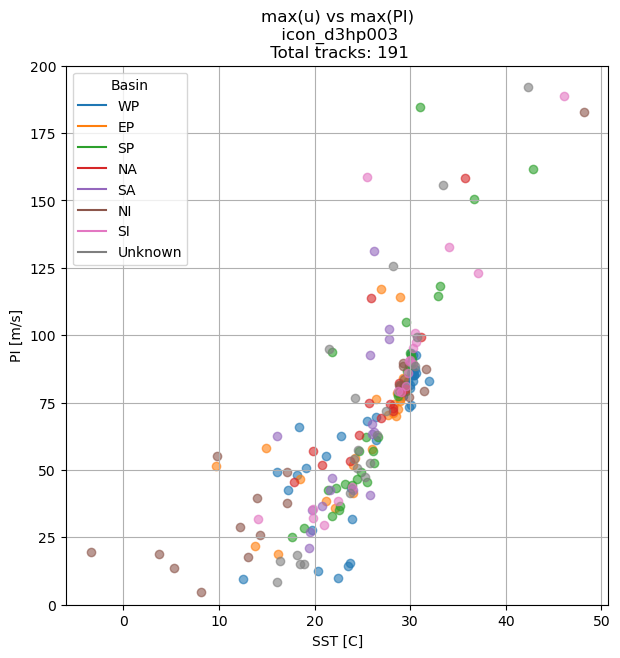

In [27]:
fig, ax = plt.subplots(figsize=(7,7))
for basin in tqdm(unique_basins):
    ds_basin = result.where(result.basin == basin, drop=True)
    for tid in np.unique(ds_basin.track_id.values):
        tsel = ds_basin.where(ds_basin.track_id == tid, drop=True)
        mask = max_sst[:,0]==tid
        ax.scatter(max_sst[mask,1], max_pi[mask,1], 
                   color=colors_basin[basin], alpha=0.6)
#ax.scatter(max_umax, max_pi, color=colors_basin)
ax.set_xlabel(f"SST [C]")
ax.set_ylabel(f"PI [m/s]")

for basin, color in colors_basin.items():
    ax.plot([], [], label=basin, color=color)
ax.legend(title="Basin")
ax.set_title(f"max(u) vs max(PI)\n {sim_name}\n Total tracks: {len(np.unique(tracks.track_id))}")

#xline = np.linspace(0, 200, 100)
#ax.plot(xline, xline, color='k')
#ax.set_xlim([0, 200])
ax.set_ylim([0, 200])
ax.grid()
fig.savefig(plot_dir+f"scatter_umax_{pi_key}_{sim_name}.png", 
            bbox_inches='tight', dpi=300)
print("Correlation: ", np.corrcoef(max_sst[:,1], max_pi[:,1])[0,1])

# PI vs T0

In [83]:
max_t0 = get_var_scatter("t0", do_min=True)
max_pi = get_var_scatter(pi_key)

Getting maxima of pi: 100%|██████████| 80/80 [00:00<00:00, 409.88it/s]


100%|██████████| 8/8 [00:00<00:00, 25.54it/s]


Correlation:  0.9165115922792865


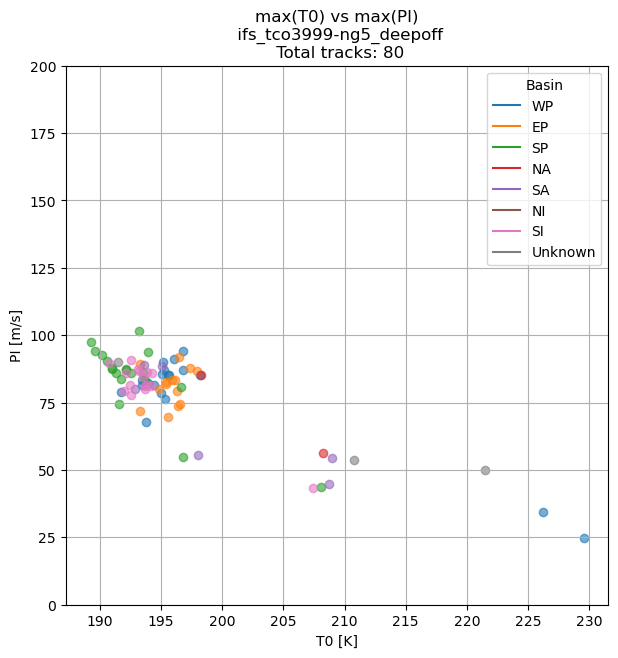

In [86]:
fig, ax = plt.subplots(figsize=(7,7))
for basin in tqdm(unique_basins):
    ds_basin = result.where(result.basin == basin, drop=True)
    for tid in np.unique(ds_basin.track_id.values):
        tsel = ds_basin.where(ds_basin.track_id == tid, drop=True)
        mask = max_sst[:,0]==tid
        ax.scatter(max_t0[mask,1], max_pi[mask,1], 
                   color=colors_basin[basin], alpha=0.6)
#ax.scatter(max_umax, max_pi, color=colors_basin)
ax.set_xlabel(f"T0 [K]")
ax.set_ylabel(f"PI [m/s]")

for basin, color in colors_basin.items():
    ax.plot([], [], label=basin, color=color)
ax.legend(title="Basin")
ax.set_title(f"max(T0) vs max(PI)\n {sim_name}\n Total tracks: {len(np.unique(tracks.track_id))}")

#xline = np.linspace(0, 200, 100)
#ax.plot(xline, xline, color='k')
#ax.set_xlim([0, 200])
ax.set_ylim([0, 200])
ax.grid()
fig.savefig(plot_dir+f"scatter_umax_pi_{sim_name}.png", 
            bbox_inches='tight', dpi=300)
print("Correlation: ", np.corrcoef(max_sst[:,1], max_pi[:,1])[0,1])

# Study each track evolution

In [111]:
corr = np.zeros((len(unique_tracks), 3))
for tid in tqdm(unique_tracks, desc=f"Getting maxima of {vname}"):
    tsel = result.where(result.track_id == tid, drop=True)
    corr[tid,0] = xr.corr(tsel[pi_key].diff("point"), tsel["wind_max"].diff("point"))
    corr[tid,1] = xr.corr(tsel[pi_key].diff("point"), tsel["sst"].diff("point"))
    corr[tid,2] = xr.corr(tsel[pi_key].diff("point"), tsel["t0"].diff("point"))

Getting maxima of vmax: 100%|██████████| 80/80 [00:00<00:00, 95.91it/s] 


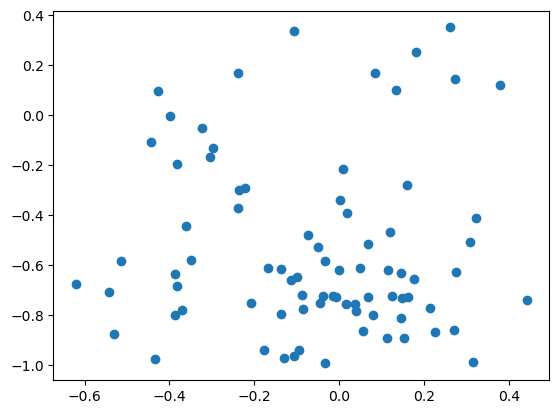

In [127]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
labels = kmeans.fit_predict(corr)
plt.scatter(corr[:,0], corr[:,2])

# Plot all tracks of any basin

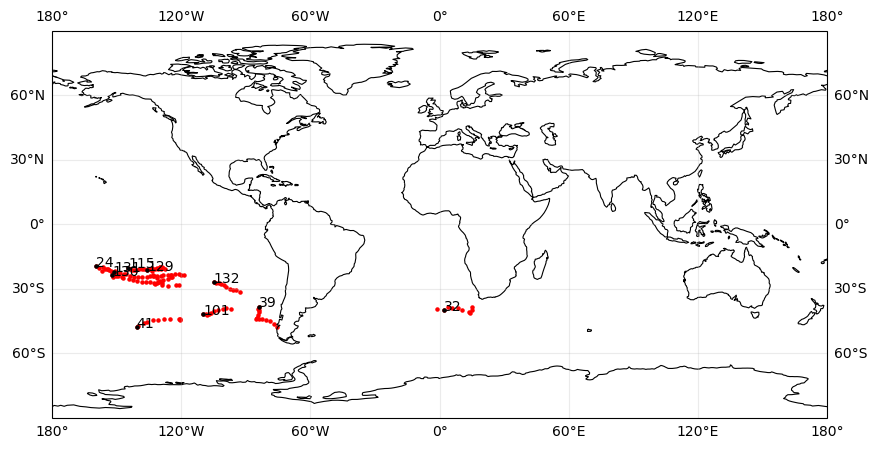

In [33]:
'''plot unknown basin results jic'''
basin_name = "Unknown"
ds_basin = result.where(result.basin == basin_name, drop=True)
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.25)
ax.set_extent([-180, 180, -90, 90])
#ax.set_extent([-85, -65, 20, 35])
ax.coastlines(lw=0.8)
ax.scatter(ds_basin.lon, ds_basin.lat, color='r', s=5)
for tid in np.unique(ds_basin.track_id):
    mask_tid = ds_basin.track_id==tid
    ax.scatter(ds_basin.where(mask_tid, drop=True).lon[0], 
               ds_basin.where(mask_tid, drop=True).lat[0], color='k', s=5)
    ax.text(ds_basin.where(mask_tid, drop=True).lon[0], 
            ds_basin.where(mask_tid, drop=True).lat[0], f"{tid:01g}", color='k', transform=ccrs.PlateCarree(), zorder=3)